In [1]:
from netCDF4 import Dataset
import netCDF4 as netcdf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib as mpl

#mapping
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import xarray as xr
import xarray.ufuncs as xu

### 1st Method (xarray)

This notebook is a demonstration of how to read HF radar data. Specifically, the HFRADAR US East and Gulf Coast 6km Resolution Hourly RTV dataset. The dataset's THREDDS catalog can be found in the link below:

https://hfrnet-tds.ucsd.edu/thredds/HFRADAR_USEGC.html

The urls have to be modified accordingly to use a different dataset.

The easiest way to read, subset and analyze large datasets in python is by using xarray.

### 1. Read

Using THREDDS catalog is helpful especially when the dataset is very large. This dataset is about 100 GB and it is efficient to read and select the parameters of interest rather than downloading it. 

In [2]:
# import the whole dataset

aggr_url = "https://hfrnet-tds.ucsd.edu/thredds/dodsC/HFR/USEGC/6km/hourly/RTV/HFRADAR_US_East_and_Gulf_Coast_6km_Resolution_Hourly_RTV_best.ncd"
data = xr.open_dataset(aggr_url)

### 2. Subset

So far we have imported the dataset which contains the whole domain (lon, lat) and time period (time). These three coordinates help us subset the dataset. In this example, the area of interest is Southern New England and the goal is to keep only data between specific longitudes and latitudes. Besides, we might need to study a specific time period. In this example I wanted to keep only data between 04-01-2021 and 05-24-2021.

In [3]:
# subset the dataset by keeping only our area of interest and a specific time period

min_lon = -75.
min_lat = 39.
max_lon = -69.
max_lat = 43.

mask_lon = (data.lon >= min_lon) & (data.lon <= max_lon)
mask_lat = (data.lat >= min_lat) & (data.lat <= max_lat)


%time subset_ds = data.sel(time=slice("2021-04-01", "2021-05-24")).where(mask_lon & mask_lat, drop=True)

Wall time: 2min 46s


### 3. Save (optional)

The HF radar dataset can also be saved as NetCDF file for future use.

In [4]:
subset_ds.to_netcdf(path='hf_radar_04-05_21.nc')

### 4. Select the closest gridpoint to the point of interest

This example is helpful for comparing gridded data with point observaions. Specifically, we want to compare HF radar data (gridded 2D fields) with the closest ADCP sensor. The sensor's coordinates are lon=-70.88174, lat=40.36708. Therefore, we will keep only data from the closest gridpoint to the ADCP longitude and latitude. Indeed, you can see below that the closest HF radar gridpoint's coordinates are: lon: -70.88, lat=40.35.

In [5]:
data2 = subset_ds.sel(lon=-70.88174, lat=40.36708, method='nearest')

If we take a look at the time series of the zonal (east-west) component, it is evident that there are gaps. We can deduce that this specific grid point is not the closest every time (hour) or that there are not available observations at this is specific gridpoint every hour. 

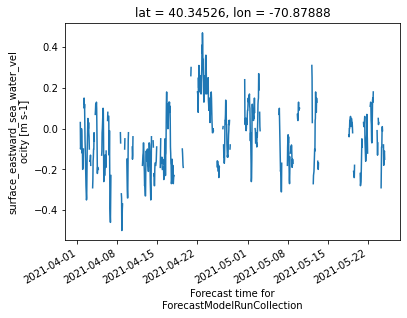

In [6]:
data2.u.plot()

### 5. Plot

For the visualization of the surface currents from HF radar, we have to select a specific time (hour). 

In [7]:
# select a specific date and time

#data1 = data.isel(time=81268)
data1 = subset_ds.sel(time='2021-05-24T23:00:00')

In [8]:
# calculate the magnitude of surface currents

CurrMag=np.sqrt(data1.u.values**2+data1.v.values**2)

In [9]:
# create the mesh for your plot
x, y = np.meshgrid(data1.lon.values,data1.lat.values)

# mask data
data_m = np.ma.masked_invalid(CurrMag)
u_m = np.ma.masked_invalid(data1.u.values)
v_m = np.ma.masked_invalid(data1.v.values)

C:\Users\PANMIT~1\AppData\Local\Temp/ipykernel_10332/1569093444.py:39: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  out=fig.colorbar(cf,cax=cax,ticks=bounds,norm=norm,extend='max',**kw)


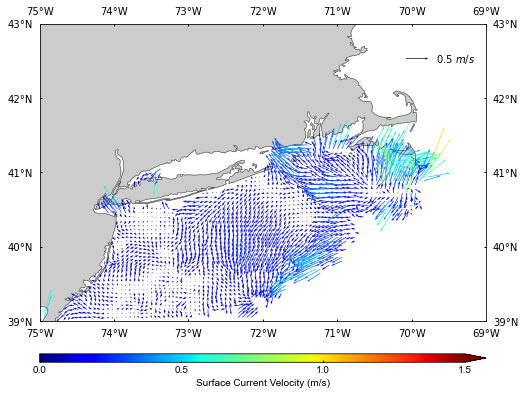

In [10]:
fig = plt.figure(figsize=(8,12))
proj = ccrs.PlateCarree()
ax=fig.add_subplot(1,1,1,projection=proj)
ax.set_extent([-75, -69, 39, 43])

mpl.rcParams['font.family'] = 'Arial'

ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter())

lon_ticks = [-75, -74, -73, -72, -71, -70, -69]
lat_ticks = [39, 40, 41, 42, 43]

ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())

ax.xaxis.set_tick_params(which='major', size=2., width=1, direction='in', top='on', pad=7)
ax.yaxis.set_tick_params(which='major', size=2., width=1, direction='in', right='on',pad=7)

ax.tick_params(labelleft=True,labelbottom=True,labeltop=True,labelright=True)  


ax.add_feature(cfeature.LAND.with_scale('10m'), color='grey', alpha=0.4)

ax.coastlines(resolution='10m',linewidth=0.3)

bounds = np.array([0.,0.5,1.,1.5])
norm = mpl.colors.Normalize(vmin=0., vmax=1.5)

# plot current vectors
cf=ax.quiver(x,y,data1.u,data1.v,data_m,cmap=plt.cm.jet,scale=10,width=.0015,norm=norm)

# add the scale for the currents magnitude
qk = ax.quiverkey(cf, 0.8, 0.58, 0.5, label='$0.5 \ m/s$', labelpos='E',
                   coordinates='figure')

# add colorbar
cax,kw = mpl.colorbar.make_axes(ax,location='bottom',pad=0.05,aspect=50)
out=fig.colorbar(cf,cax=cax,ticks=bounds,norm=norm,extend='max',**kw)
out.set_label('Surface Current Velocity (m/s)',size=10)
out.ax.tick_params(direction='in',size=2., width=1)

#plt.savefig('hf_radar.svg', format='svg', transparent=False, dpi=300, bbox_inches='tight')
plt.savefig('hf_radar.png', format='png', transparent=False, dpi=300, bbox_inches='tight')

### 2nd Method (netcdf library)

I also included an example of reading and plotting the HF radar data using the NetCDF python library because it is a very popular library for reading NetCDF files and you might consider using it in the future.

In [11]:
# import dataset

netcdf_data = Dataset('https://hfrnet-tds.ucsd.edu/thredds/dodsC/HFR/USEGC/6km/hourly/RTV/HFRADAR_US_East_and_Gulf_Coast_6km_Resolution_Hourly_RTV_best.ncd')


In [12]:
for variable in netcdf_data.variables:
    print(variable,netcdf_data.variables[variable].shape)

lat (460,)
lon (701,)
time (82975,)
time_run (82975,)
time_bnds (1, 2)
depth_bnds (2,)
wgs84 ()
processing_parameters ()
radial_metadata ()
depth ()
time_offset (82975,)
u (82975, 460, 701)
v (82975, 460, 701)
dopx (82975, 460, 701)
dopy (82975, 460, 701)
hdop (82975, 460, 701)
number_of_sites (82975, 460, 701)
number_of_radials (82975, 460, 701)


In [13]:
lat=netcdf_data.variables['lat'][:]
lon=netcdf_data.variables['lon'][:]
time=netcdf_data.variables['time'][:]

In [14]:
latest_time_index=int(len(time))-4

In [15]:
latest_time_index

82971

In [16]:
u=netcdf_data.variables['u'][latest_time_index,:,:];
v=netcdf_data.variables['v'][latest_time_index,:,:];

In [17]:
# calculate the currents magnitude

CurrMag=np.sqrt(u**2+v**2)

C:\Users\PANMIT~1\AppData\Local\Temp/ipykernel_10332/1988096458.py:47: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  out=fig.colorbar(cf,cax=cax,ticks=bounds,norm=norm,extend='max',**kw)


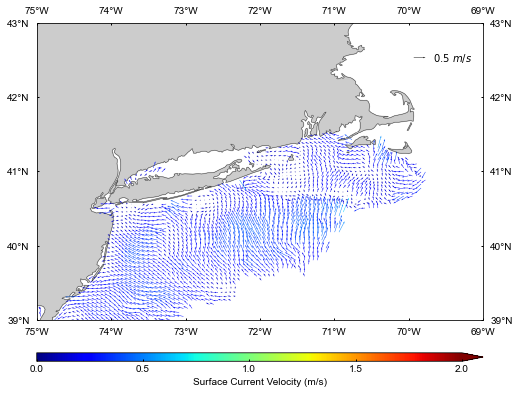

In [18]:
fig = plt.figure(figsize=(8,12))
proj = ccrs.PlateCarree()
ax=fig.add_subplot(1,1,1,projection=proj)
ax.set_extent([-75, -69, 39, 43])

mpl.rcParams['font.family'] = 'Arial'

ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter())

lon_ticks = [-75, -74, -73, -72, -71, -70, -69]
lat_ticks = [39, 40, 41, 42, 43]

ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())

ax.xaxis.set_tick_params(which='major', size=2., width=1, direction='in', top='on', pad=7)
ax.yaxis.set_tick_params(which='major', size=2., width=1, direction='in', right='on',pad=7)

ax.tick_params(labelleft=True,labelbottom=True,labeltop=True,labelright=True)  

ax.add_feature(cfeature.LAND.with_scale('10m'), color='grey', alpha=0.4)

ax.coastlines(resolution='10m',linewidth=0.3)
bounds = np.array([0.,0.5,1.,1.5,2.])
norm = mpl.colors.Normalize(vmin=0., vmax=2.)

# convert the lat/lon values to x/y projections.
x, y = np.meshgrid(lon,lat)

# mask data
data_m = np.ma.masked_invalid(CurrMag)
u_m = np.ma.masked_invalid(u)
v_m = np.ma.masked_invalid(v)

#  plot current vectors
cf=ax.quiver(x,y,u,v,data_m,cmap=plt.cm.jet,scale=19,width=.001,norm=norm)
#cs2=ax.quiver(x,y,u,v,data_m,cmap=plt.cm.jet)
#plt.colorbar(CF,label="Speed (m/s)",orientation='horizontal')

qk = ax.quiverkey(cf, 0.8, 0.58, 0.5, label='$0.5 \ m/s$', labelpos='E',
                   coordinates='figure')


cax,kw = mpl.colorbar.make_axes(ax,location='bottom',pad=0.05,aspect=50)

out=fig.colorbar(cf,cax=cax,ticks=bounds,norm=norm,extend='max',**kw)
out.set_label('Surface Current Velocity (m/s)',size=10)
out.ax.tick_params(direction='in',size=2., width=1)

plt.savefig('hf_radar_alt.png', dpi=300, transparent=False, bbox_inches='tight')